Here I move directly to training the yield forecasting model.

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression 
SEED=2020
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 1000) 

In [36]:
#load datasets
df_train = pd.read_csv(r'F:\DS\Kernel\data\train_clean.csv')
df_test = pd.read_csv(r'F:\DS\Kernel\data\test_clean.csv')
df_train.shape, df_test.shape

((5561, 237), (2187, 237))

In [37]:
# split to test/train
X = df_train.drop(['logYield','Field','Yield'], axis=1) 
y = df_train['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

To reduce the dimension of the feature space, I use a tool from the RFECV library, which recursively removes features that do not affect the performance of the model.

In [38]:

estimator =  DecisionTreeRegressor(random_state=SEED)
selector = RFECV(estimator, step=3, min_features_to_select=1, cv=3, scoring='neg_mean_absolute_error', verbose=0)
selector = selector.fit(X_train, y_train)
f = selector.get_support(1)
X_train = X_train[X_train.columns[f]]
X_test = X_test[X_test.columns[f]]

In [39]:
X_train.shape

(4448, 114)

I managed to reduce the feature space from 237 to 114, including removing multicollinear features that were present in large quantities in the dataset

Next, I move on to training the model, simultaneously optimizing its hyperparameters.

## Median Absolute Percentage Error (MdAPE)

The Median Absolute Percentage Error (MdAPE) is a statistical measure used to evaluate the accuracy of predictive models, particularly in the field of crop yield forecasting. It represents the median of the absolute differences between predicted and actual values, expressed as a percentage of the actual values.

### Advantages of MdAPE in Crop Yield Prediction:

- **Robustness to Outliers**: Unlike the mean absolute percentage error (MAPE), MdAPE is not sensitive to outliers. Crop yield data can be highly variable and susceptible to extreme values due to factors such as weather anomalies or pest infestations. MdAPE provides a more reliable measure of central tendency.

- **Interpretability**: MdAPE offers a straightforward interpretation — the median proportion by which the predictive model's estimates deviate from the actual outcomes. This clarity is valuable for agricultural stakeholders who need to understand model performance without delving into complex statistical details.

- **Scalability**: It scales well for both small-scale and large-scale agricultural data, making it versatile for different types of crop yield prediction, from individual farms to regional assessments.

- **Non-Negativity**: The percentage error by nature cannot be negative, which prevents the cancellation of error terms when aggregating overall performance, ensuring a truthful representation of model accuracy.

- **Unit Agnosticism**: MdAPE is unitless, which allows for the comparison of model performance across different crops and regions, regardless of the units of measurement, such as bushels per acre or kilograms per hectare.

Overall, MdAPE is a practical and efficient metric for evaluating crop yield predictions. Its user-friendly nature and resistance to skewed data make it an excellent choice for accurately assessing the performance of predictive models in agriculture.


Optimizing num_leaves: 100%|██████████| 95/95 [01:14<00:00,  1.28it/s]


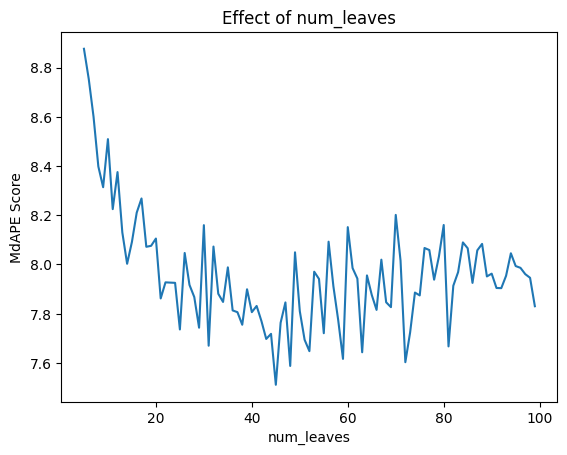

Best num_leaves: 45 with MdAPE: 7.510974150702161


Optimizing max_depth: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]


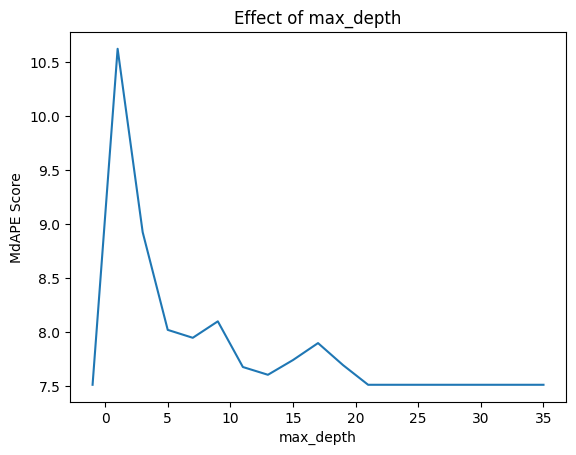

Best max_depth: -1 with MdAPE: 7.510974150702161


Optimizing learning_rate: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


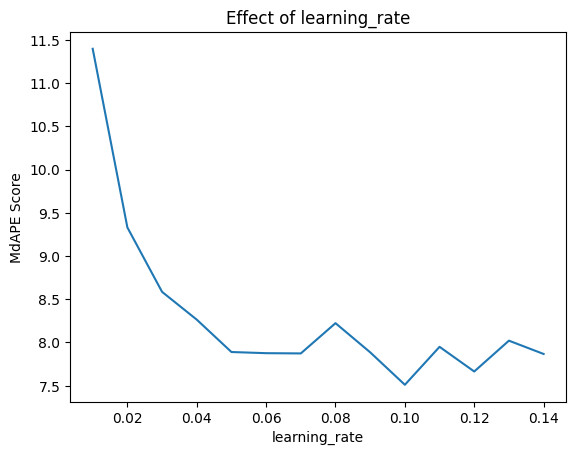

Best learning_rate: 0.09999999999999999 with MdAPE: 7.510974150702161


Optimizing n_estimators: 100%|██████████| 151/151 [01:43<00:00,  1.46it/s]


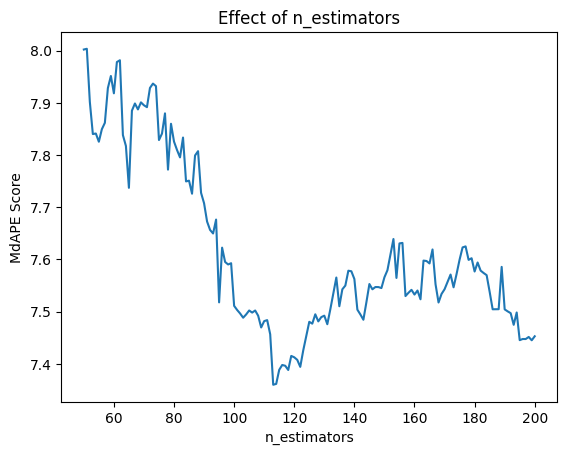

Best n_estimators: 113 with MdAPE: 7.359706749764543


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from tqdm import tqdm  # Import tqdm

def mdape(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def optimize_and_plot(param_name, param_values, fixed_params):
    scores = []
    for value in tqdm(param_values, desc=f"Optimizing {param_name}"):  # Add tqdm progress bar here
        params = fixed_params.copy()
        params[param_name] = value

        model = LGBMRegressor(**params)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        # score = mdape(np.expm1(y_test), np.expm1(predictions))
        score = mdape((y_test), (predictions))

        scores.append(score)

    plt.figure()
    plt.title(f"Effect of {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("MdAPE Score")
    plt.plot(param_values, scores)
    plt.show()

    best_value = param_values[np.argmin(scores)]
    print(f"Best {param_name}: {best_value} with MdAPE: {min(scores)}")

    return best_value

# params initialization
fixed_params = {
    # 'learning_rate': 0.1,
    # 'max_depth':-1,
    'min_child_samples': 20,
    # 'max_bin': 1500,
    'random_state': SEED,
    # 'colsample_bytree': 0.92
}

# params optimization
num_leaves_values = np.arange(5, 100, 1)
best_num_leaves = optimize_and_plot('num_leaves', num_leaves_values, fixed_params)
fixed_params['num_leaves'] = best_num_leaves

# min_child_samples_values = np.arange(18, 42, 2)
# best_min_child_samples = optimize_and_plot('min_child_samples', min_child_samples_values, fixed_params)
# fixed_params['min_child_samples'] = best_min_child_samples

max_depth_values = np.arange(-1, 37, 2)
best_max_depth = optimize_and_plot('max_depth', max_depth_values, fixed_params)
fixed_params['max_depth'] = best_max_depth

learning_rate_values = np.arange(0.01, 0.15, 0.01)
best_learning_rate = optimize_and_plot('learning_rate', learning_rate_values, fixed_params)
fixed_params['learning_rate'] = best_learning_rate

# colsample_bytree_values = np.arange(0.5, 1.0, 0.1)
# best_colsample_bytree = optimize_and_plot('colsample_bytree', colsample_bytree_values, fixed_params)
# fixed_params['colsample_bytree'] = best_colsample_bytree


n_estimators_values = np.arange(50, 201, 1)
best_n_estimators = optimize_and_plot('n_estimators', n_estimators_values, fixed_params)
fixed_params['n_estimators'] = best_n_estimators


In [41]:
# train model with optimal params
model = LGBMRegressor(**fixed_params)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# score = mdape(np.expm1(y_test), np.expm1(predictions))
score = mdape((y_test), (predictions))
score

7.359706749764543

I evaluate the model by the importance of features

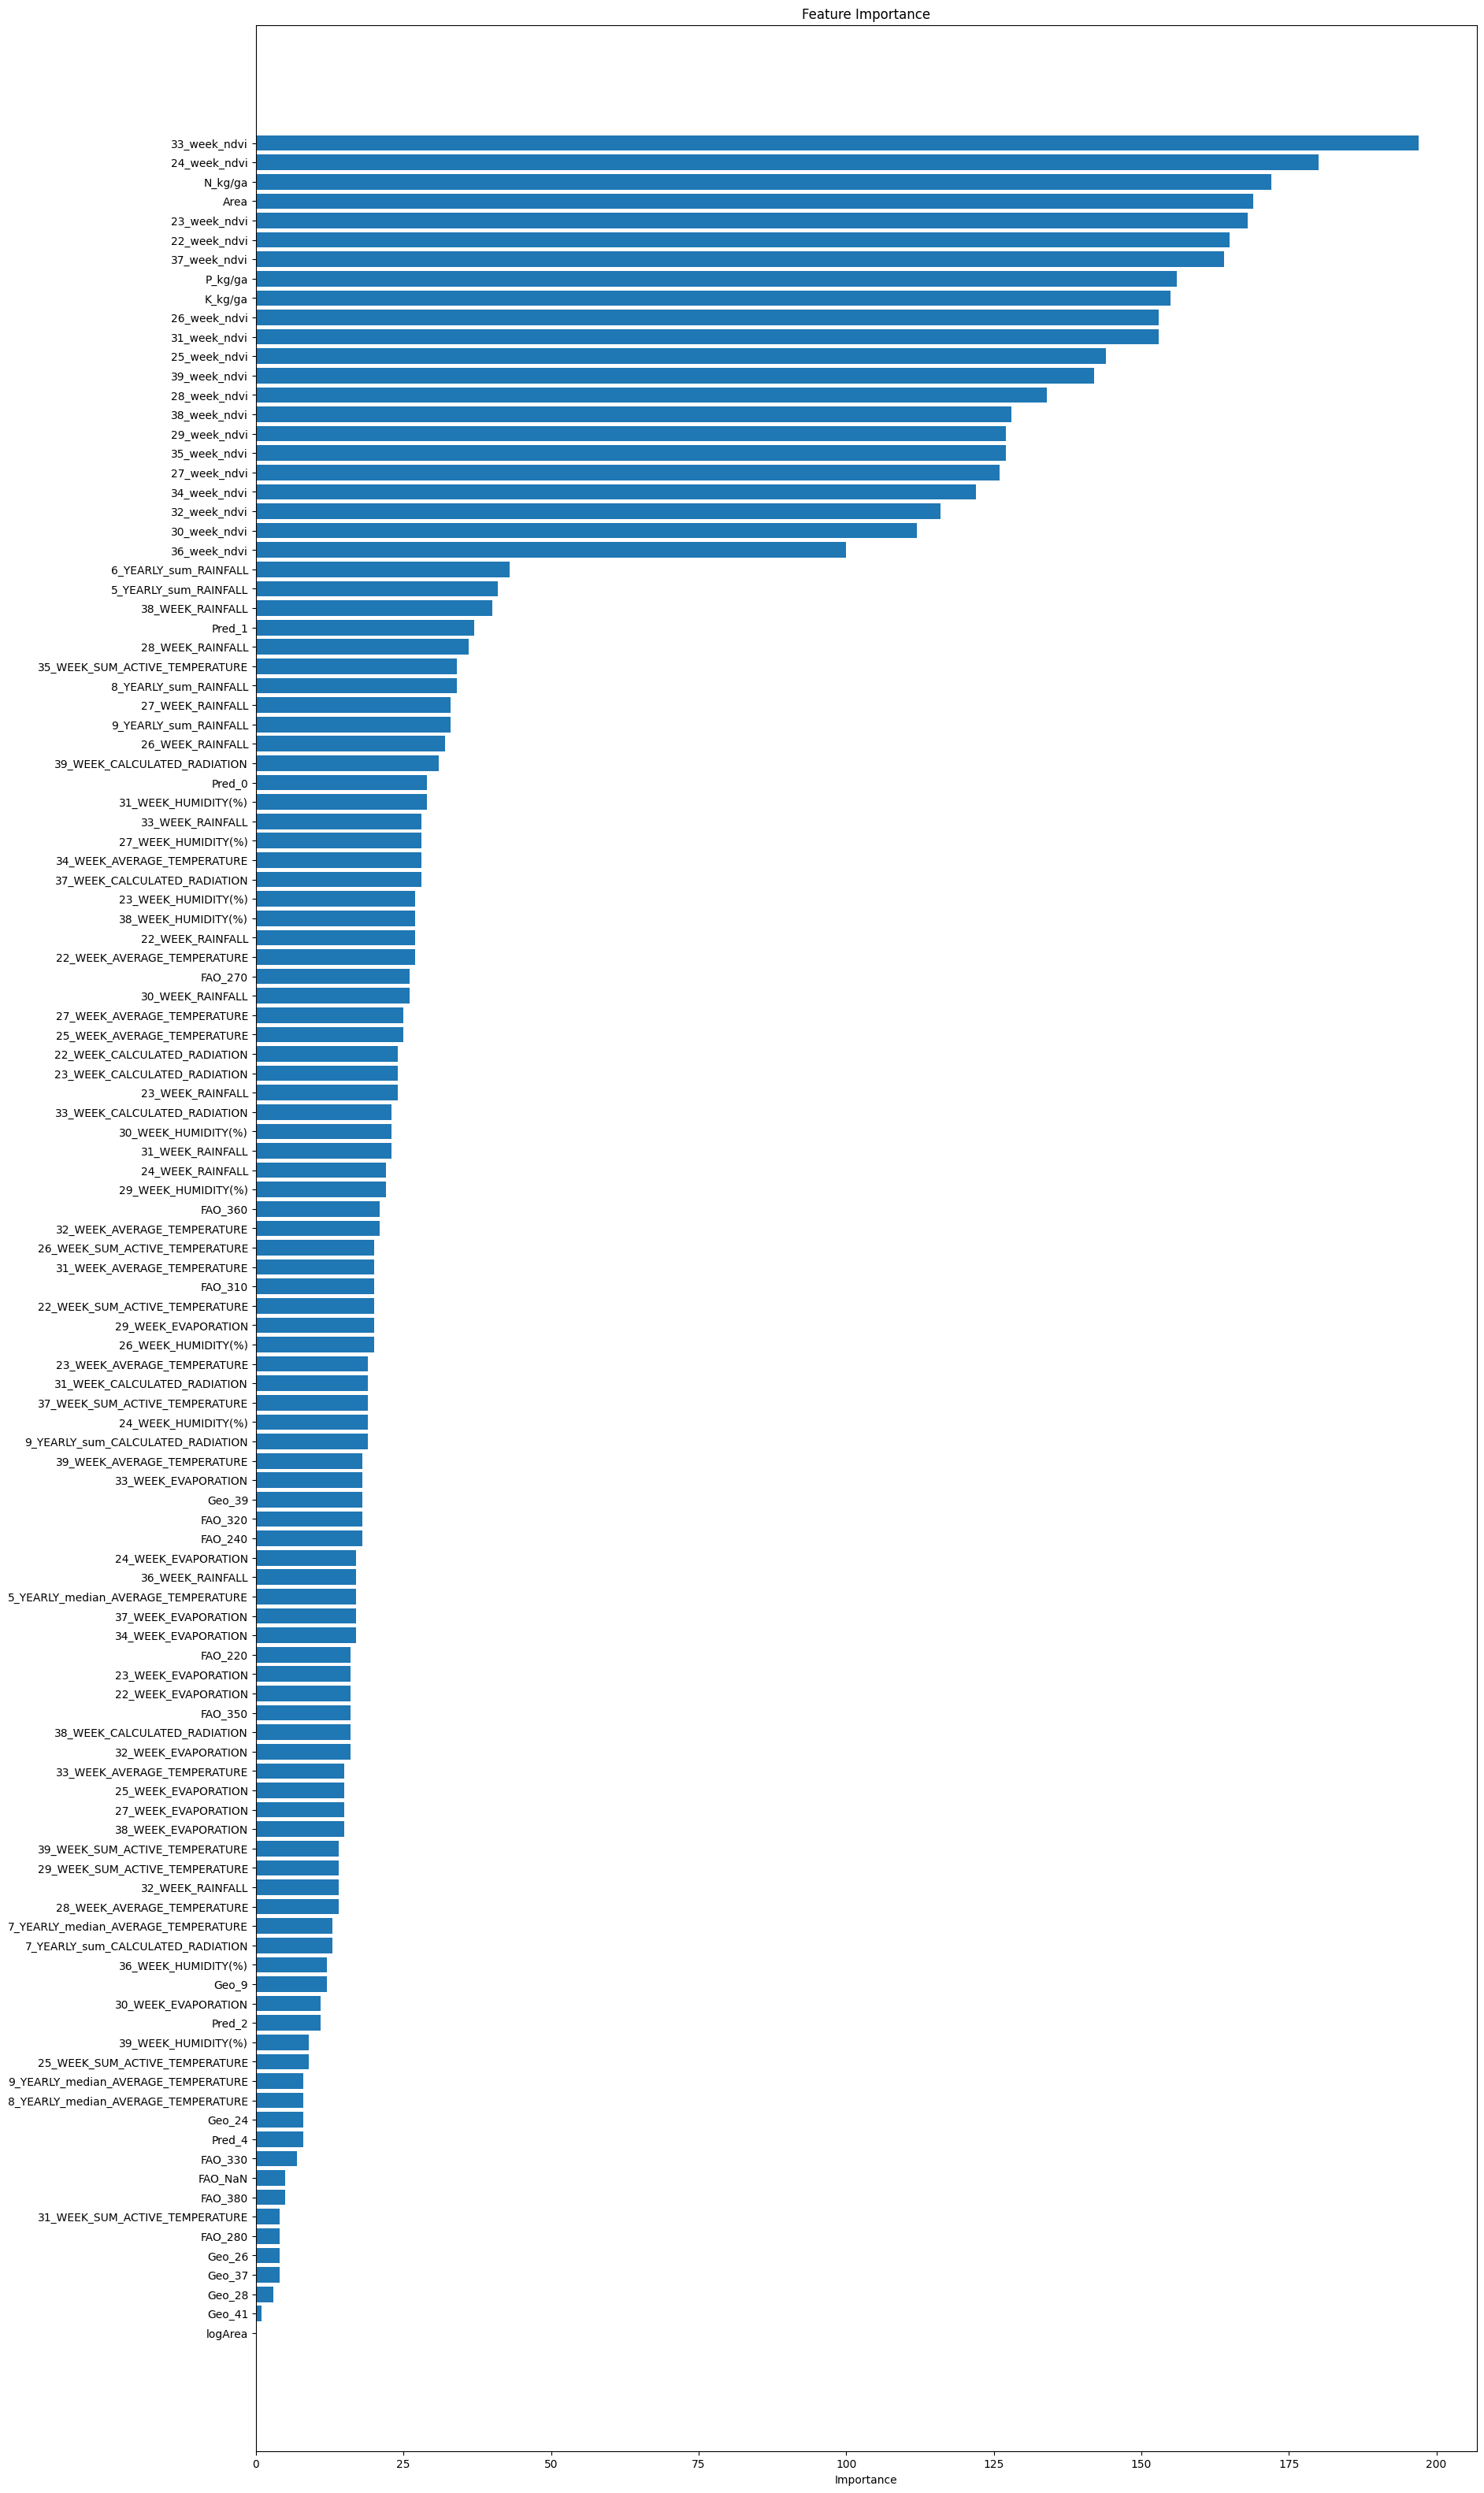

In [42]:
plt.figure(figsize=(20, 40))
plt.title('Feature Importance')
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(model.feature_name_)[sorted_idx])
plt.xlabel('Importance')
plt.show()

##  Yield Prediction Model: Feature Importance Analysis

The feature importance graph delineates the impact of various variables on the crop yield prediction model. Here's an in-depth look at the notable features:

- **NDVI Metrics**: Features like '33_week_ndvi' and other 'week_ndvi' variables demonstrate strong predictive power, emphasizing the importance of vegetation health and growth patterns at specific times in the growing season.

- **Climate Factors**: Rainfall and temperature-related features, such as '6_YEARLY_SUM_RAINFALL', '5_YEARLY_SUM_RAINFALL' and '35_WEEK_SUM_RAINFALL', are crucial, reflecting the influence of weather conditions on agricultural productivity.

- **Fertilization Indicators**: The metric 'N_kg/ha', which  represents the amount of Nitrogen applied per hectare, is a prominent factor. This suggests that fertilizer application rates are significant predictors of yield, highlighting the role of nutrient management in crop production.

- **Land Area**: The feature 'Area' is observed to have considerable importance, indicating that the size of the cultivated land is a key factor in yield outcomes, possibly due to its relation to economies of scale and the intensity of agricultural practices.


In summary, the model underscores the multifaceted nature of crop yield determinants, encompassing immediate and historical weather conditions, soil fertility management, and farm operational scale. Understanding these factors can empower stakeholders to make informed decisions aimed at enhancing agricultural yields.


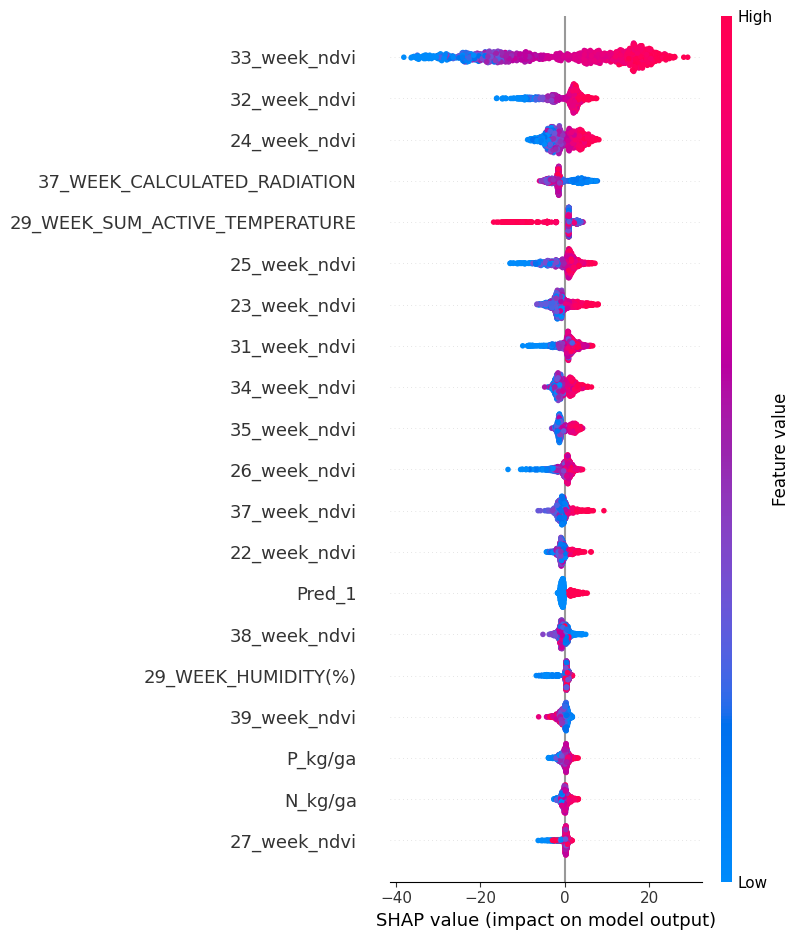

In [43]:
import sys
sys.path.append('F:\\DS\\Kernel\\env\\Lib\\site-packages')
import shap  # Теперь попробуйте импортировать shap
# Create object that can calculate shap values 
explainer = shap.TreeExplainer(model) 
# calculate shap values. This is what we will plot. 
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot. 
shap_values = explainer.shap_values(X_test) 
# Make plot. Index of [1] is explained in text below. 
shap.summary_plot(shap_values, X_test)

## Qualitative Analysis of SHAP Values Visualization

The SHAP (SHapley Additive exPlanations) values visualization provides a nuanced view of the impact each feature has on the model's predictions. Below is a qualitative analysis of the SHAP beeswarm plot:

- **Color Coding**: Features are color-coded to indicate the value of the feature, with pink representing high values and blue representing low values. The intensity of the color corresponds to the feature value's extremity.

- **Feature Impact**: The horizontal position of each dot signifies the impact of the feature value on the model's prediction. Dots that appear to the right of the zero line on the x-axis increase the prediction, while those to the left decrease the prediction.

- **Vertical Positioning**: Features are listed in descending order of importance, with the most impactful features at the top of the plot. This indicates the rank of feature importance in influencing the model output.

- **Density of Points**: The density of the dots along the x-axis reveals the distribution of the SHAP values for each feature. A wider spread of dots indicates a larger variety of impact on the predictions, while a narrower spread indicates more consistency in the feature's effect.

- **Week-specific NDVI Indicators**: NDVI features corresponding to specific weeks (e.g., `33_week_ndvi`, `32_week_ndvi`, etc.) are prominent, suggesting that the timing of NDVI measurements is crucial for predicting outcomes.

- **Climatic Variables**: Features such as `37_WEEK_CALCULATED_RADIATION` and `29_WEEK_SUM_ACTIVE_TEMPERATURE` appear to have a significant influence on the model's predictions, reflecting the importance of environmental factors.

- **Fertilizer Usage**: The features `P_kg/ga` and `N_kg/ga`, representing phosphorus and nitrogen applied per hectare, respectively, are also influential, albeit to a lesser extent than the top climatic features and NDVI indicators. This shows the relevance of nutrient availability in determining crop yields.

- **Outliers and Extremes**: Some features have SHAP values with extreme positive or negative effects. These outliers may indicate instances where the features had unusually high or low values, leading to significant deviation in the predicted outcome.

Overall, the visualization underscores the complexity of the factors influencing crop yield predictions, with both environmental and agronomic variables playing critical roles. Such insights can facilitate more targeted and effective agricultural practices.


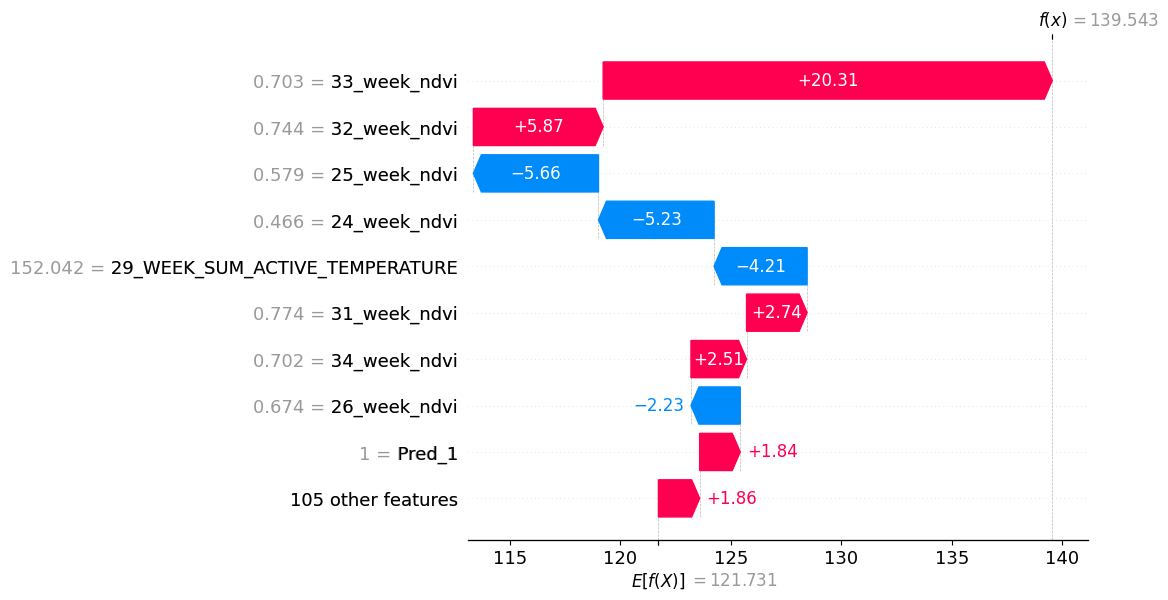

In [44]:
explainer = shap.Explainer(model) 
shap_values = explainer(X_train) 
# visualize the first prediction's explanation 
shap.plots.waterfall(shap_values[0])

## SHAP Summary Plot Analysis for Yield Prediction

The SHAP summary plot provides a visual representation of the feature contributions to a predictive model's output. Below is a qualitative analysis of the provided SHAP summary plot:

- **Top Features**: The '33_week_ndvi' feature has the highest positive impact on the model's output, with a SHAP value of approximately +20.31, indicating that higher NDVI readings at this stage are strongly associated with increased crop yield predictions.

- **Positive and Negative Impacts**: Features such as '32_week_ndvi' and '31_week_ndvi' also show a positive influence, with SHAP values of +5.87 and +2.74, respectively. Conversely, '25_week_ndvi' and '24_week_ndvi' demonstrate a negative impact on the model output, with SHAP values of -5.66 and -5.23.

- **Climate Factors**: The feature '29_WEEK_SUM_ACTIVE_TEMPERATURE' has a notable negative contribution, with a SHAP value of -4.21, suggesting that higher accumulated temperatures during this period may be associated with lower yield predictions.

- **Predictor Feature**: The feature 'Pred_1' shows a modest positive contribution with a SHAP value of +1.84, implying its relevance in the prediction alongside more direct agricultural indicators.

- **Aggregated Impact**: The plot also aggregates the impact of 105 other features at the bottom, which collectively have a slight positive impact on the model output, signifying that while individually less significant, together they still play a role in the model's predictions.

- **Expected Value**: The base value, `E[f(X)]`, is marked at 121.731, which is the prediction that would be made if no features were available. The output value `f(X)` of 139.543 is the actual prediction for the instance, influenced by the individual SHAP values of each feature.

In summary, the SHAP summary plot underscores the importance of specific NDVI measurements throughout the growing season, the impact of temperature accumulation, and highlights the mixed effects of other agronomic and environmental features. Such detailed insights are invaluable for understanding the dynamics of crop yield prediction and can guide more precise agricultural strategies.


I'm moving on to the final part: predicting test set yield

In [45]:
X_model_train = X[X.columns[f]] # rfecv filter
X_test_predict = df_test.drop(['logYield','Field','Yield'], axis=1) # split final set for prediction
X_test_predict = X_test_predict[X_test_predict.columns[f]] # rfecv filter for final set

In [47]:
# train model with optimal params on total dataset
model = LGBMRegressor(**fixed_params)
model.fit(X_model_train, y)
predictions = model.predict(X_test_predict)

In [49]:
df_test['Yield_pred'] = predictions

In [50]:
df_test.sample()

,Field,Area,Yield,Pred_0,Pred_1,Pred_2,Pred_3,Pred_4,N_kg/ga,P_kg/ga,K_kg/ga,5_YEARLY_median_AVERAGE_TEMPERATURE,6_YEARLY_median_AVERAGE_TEMPERATURE,7_YEARLY_median_AVERAGE_TEMPERATURE,8_YEARLY_median_AVERAGE_TEMPERATURE,9_YEARLY_median_AVERAGE_TEMPERATURE,5_YEARLY_median_EVAPORATION,6_YEARLY_median_EVAPORATION,7_YEARLY_median_EVAPORATION,8_YEARLY_median_EVAPORATION,9_YEARLY_median_EVAPORATION,5_YEARLY_median_HUMIDITY(%),6_YEARLY_median_HUMIDITY(%),7_YEARLY_median_HUMIDITY(%),8_YEARLY_median_HUMIDITY(%),9_YEARLY_median_HUMIDITY(%),5_YEARLY_sum_CALCULATED_RADIATION,6_YEARLY_sum_CALCULATED_RADIATION,7_YEARLY_sum_CALCULATED_RADIATION,8_YEARLY_sum_CALCULATED_RADIATION,9_YEARLY_sum_CALCULATED_RADIATION,5_YEARLY_sum_RAINFALL,6_YEARLY_sum_RAINFALL,7_YEARLY_sum_RAINFALL,8_YEARLY_sum_RAINFALL,9_YEARLY_sum_RAINFALL,22_WEEK_AVERAGE_TEMPERATURE,23_WEEK_AVERAGE_TEMPERATURE,24_WEEK_AVERAGE_TEMPERATURE,25_WEEK_AVERAGE_TEMPERATURE,26_WEEK_AVERAGE_TEMPERATURE,27_WEEK_AVERAGE_TEMPERATURE,28_WEEK_AVERAGE_TEMPERATURE,29_WEEK_AVERAGE_TEMPERATURE,30_WEEK_AVERAGE_TEMPERATURE,31_WEEK_AVERAGE_TEMPERATURE,32_WEEK_AVERAGE_TEMPERATURE,33_WEEK_AVERAGE_TEMPERATURE,34_WEEK_AVERAGE_TEMPERATURE,35_WEEK_AVERAGE_TEMPERATURE,36_WEEK_AVERAGE_TEMPERATURE,37_WEEK_AVERAGE_TEMPERATURE,38_WEEK_AVERAGE_TEMPERATURE,39_WEEK_AVERAGE_TEMPERATURE,22_WEEK_CALCULATED_RADIATION,23_WEEK_CALCULATED_RADIATION,24_WEEK_CALCULATED_RADIATION,25_WEEK_CALCULATED_RADIATION,26_WEEK_CALCULATED_RADIATION,27_WEEK_CALCULATED_RADIATION,28_WEEK_CALCULATED_RADIATION,29_WEEK_CALCULATED_RADIATION,30_WEEK_CALCULATED_RADIATION,31_WEEK_CALCULATED_RADIATION,32_WEEK_CALCULATED_RADIATION,33_WEEK_CALCULATED_RADIATION,34_WEEK_CALCULATED_RADIATION,35_WEEK_CALCULATED_RADIATION,36_WEEK_CALCULATED_RADIATION,37_WEEK_CALCULATED_RADIATION,38_WEEK_CALCULATED_RADIATION,39_WEEK_CALCULATED_RADIATION,22_WEEK_EVAPORATION,23_WEEK_EVAPORATION,24_WEEK_EVAPORATION,25_WEEK_EVAPORATION,26_WEEK_EVAPORATION,27_WEEK_EVAPORATION,28_WEEK_EVAPORATION,29_WEEK_EVAPORATION,30_WEEK_EVAPORATION,31_WEEK_EVAPORATION,32_WEEK_EVAPORATION,33_WEEK_EVAPORATION,34_WEEK_EVAPORATION,35_WEEK_EVAPORATION,36_WEEK_EVAPORATION,37_WEEK_EVAPORATION,38_WEEK_EVAPORATION,39_WEEK_EVAPORATION,22_WEEK_HUMIDITY(%),23_WEEK_HUMIDITY(%),24_WEEK_HUMIDITY(%),25_WEEK_HUMIDITY(%),26_WEEK_HUMIDITY(%),27_WEEK_HUMIDITY(%),28_WEEK_HUMIDITY(%),29_WEEK_HUMIDITY(%),30_WEEK_HUMIDITY(%),31_WEEK_HUMIDITY(%),32_WEEK_HUMIDITY(%),33_WEEK_HUMIDITY(%),34_WEEK_HUMIDITY(%),35_WEEK_HUMIDITY(%),36_WEEK_HUMIDITY(%),37_WEEK_HUMIDITY(%),38_WEEK_HUMIDITY(%),39_WEEK_HUMIDITY(%),22_WEEK_RAINFALL,23_WEEK_RAINFALL,24_WEEK_RAINFALL,25_WEEK_RAINFALL,26_WEEK_RAINFALL,27_WEEK_RAINFALL,28_WEEK_RAINFALL,29_WEEK_RAINFALL,30_WEEK_RAINFALL,31_WEEK_RAINFALL,32_WEEK_RAINFALL,33_WEEK_RAINFALL,34_WEEK_RAINFALL,35_WEEK_RAINFALL,36_WEEK_RAINFALL,37_WEEK_RAINFALL,38_WEEK_RAINFALL,39_WEEK_RAINFALL,22_WEEK_SUM_ACTIVE_TEMPERATURE,23_WEEK_SUM_ACTIVE_TEMPERATURE,24_WEEK_SUM_ACTIVE_TEMPERATURE,25_WEEK_SUM_ACTIVE_TEMPERATURE,26_WEEK_SUM_ACTIVE_TEMPERATURE,27_WEEK_SUM_ACTIVE_TEMPERATURE,28_WEEK_SUM_ACTIVE_TEMPERATURE,29_WEEK_SUM_ACTIVE_TEMPERATURE,30_WEEK_SUM_ACTIVE_TEMPERATURE,31_WEEK_SUM_ACTIVE_TEMPERATURE,32_WEEK_SUM_ACTIVE_TEMPERATURE,33_WEEK_SUM_ACTIVE_TEMPERATURE,34_WEEK_SUM_ACTIVE_TEMPERATURE,35_WEEK_SUM_ACTIVE_TEMPERATURE,36_WEEK_SUM_ACTIVE_TEMPERATURE,37_WEEK_SUM_ACTIVE_TEMPERATURE,38_WEEK_SUM_ACTIVE_TEMPERATURE,39_WEEK_SUM_ACTIVE_TEMPERATURE,22_week_ndvi,23_week_ndvi,24_week_ndvi,25_week_ndvi,26_week_ndvi,27_week_ndvi,28_week_ndvi,29_week_ndvi,30_week_ndvi,31_week_ndvi,32_week_ndvi,33_week_ndvi,34_week_ndvi,35_week_ndvi,36_week_ndvi,37_week_ndvi,38_week_ndvi,39_week_ndvi,FAO_NaN,FAO_180,FAO_200,FAO_220,FAO_240,FAO_250,FAO_260,FAO_270,FAO_280,FAO_290,FAO_300,FAO_310,FAO_320,FAO_330,FAO_340,FAO_350,FAO_360,FAO_370,FAO_380,FAO_390,FAO_400,FAO_420,FAO_440,Geo_0,Geo_1,Geo_2,Geo_3,Geo_4,Geo_5,Geo_6,Geo_7,Geo_8,Geo_9,Geo_10,Geo_11,Geo_12,Geo_13,Geo_14,Geo_15,Geo_16,Geo_17,Geo_18,Geo_19,Geo_20,Geo_21,Geo_22,Geo_

In [52]:
# Weighted yield calculation
weighted_yields = {}

for i in range(7):
    cluster_mask = df_test[f'Cluster_{i}'] == 1

    if cluster_mask.any():
        weighted_yield = (df_test.loc[cluster_mask, 'Area'] * df_test.loc[cluster_mask, 'Yield_pred']).sum() / \
                         df_test.loc[cluster_mask, 'Area'].sum()
    else:
        weighted_yield = 0  
    weighted_yields[f'Cluster_{i}'] = weighted_yield

# Create new df with results
df_cluster_weighted_yields = pd.DataFrame(list(weighted_yields.items()), columns=['Cluster', 'Weighted_Yield'])

df_cluster_weighted_yields  # new df output


,Cluster,Weighted_Yield
0,Cluster_0,135.581335
1,Cluster_1,133.774860
2,Cluster_2,101.484397
3,Cluster_3,76.865614
4,Cluster_4,93.279858
5,Cluster_5,66.693056
6,Cluster_6,83.171666


In [55]:
final_prediction = df_test[['Field', 'Yield_pred']]

In [58]:
final_prediction.to_csv(r'F:\DS\Kernel\data\pred_yield.csv', index=False, sep=',')

In [59]:
df_cluster_weighted_yields.to_csv(r'F:\DS\Kernel\data\weighted_yield.csv', index=False, sep=',')

Thus, I received Yield forecasts for 2020 and calculated the weighted average forecast for clusters(pred_yield.csv, weighted_yield.csv)

## Future Steps

To build upon our current understanding and methodologies for crop yield forecasting, the following initiatives are proposed:

### Data Enhancement
- **Seasonal Weather Patterns**: Incorporate more detailed seasonal weather pattern data to better understand their long-term effects on crop yields.
- **Soil Quality Metrics**: Add soil quality metrics to our dataset to assess their influence on yield variations.

### Methodology Adjustments
- **Short-Term Forecasts**: Develop shorter-term forecasting models that can provide more immediate insights for on-the-ground agricultural decisions.
- **Historical Analysis**: Extend our analysis to include historical yield data to identify trends and patterns over time.

### Technology Utilization
- **Satellite Imagery**: Utilize satellite imagery to gather additional data points on crop health and growth rates throughout the season.
- **Mobile Applications**: Create mobile applications that allow for easy data collection and yield forecasting on the go.

By taking these steps, we aim to improve our crop yield forecasting methods, making them more robust, locally relevant, and user-friendly for the farming community.


In [68]:
from sklearn.tree import DecisionTreeRegressor, export_text
surrogate_model = DecisionTreeRegressor(max_depth=5)  
surrogate_model.fit(X_test_predict, predictions)


DecisionTreeRegressor(max_depth=5)

In [69]:
tree_rules = export_text(surrogate_model, feature_names=list(X_train.columns))
print(tree_rules)


|--- 33_week_ndvi <= 0.65
|   |--- 32_week_ndvi <= 0.62
|   |   |--- 32_week_ndvi <= 0.55
|   |   |   |--- N_kg/ga <= 116.37
|   |   |   |   |--- 33_week_ndvi <= 0.45
|   |   |   |   |   |--- value: [50.44]
|   |   |   |   |--- 33_week_ndvi >  0.45
|   |   |   |   |   |--- value: [63.12]
|   |   |   |--- N_kg/ga >  116.37
|   |   |   |   |--- 30_week_ndvi <= 0.65
|   |   |   |   |   |--- value: [62.91]
|   |   |   |   |--- 30_week_ndvi >  0.65
|   |   |   |   |   |--- value: [70.24]
|   |   |--- 32_week_ndvi >  0.55
|   |   |   |--- 33_week_ndvi <= 0.55
|   |   |   |   |--- 31_week_ndvi <= 0.65
|   |   |   |   |   |--- value: [75.35]
|   |   |   |   |--- 31_week_ndvi >  0.65
|   |   |   |   |   |--- value: [83.63]
|   |   |   |--- 33_week_ndvi >  0.55
|   |   |   |   |--- 34_week_ndvi <= 0.56
|   |   |   |   |   |--- value: [93.17]
|   |   |   |   |--- 34_week_ndvi >  0.56
|   |   |   |   |   |--- value: [108.26]
|   |--- 32_week_ndvi >  0.62
|   |   |--- 33_week_ndvi <= 0.58
|   |   |

## Global Surrogate Models: Insights from Decision Tree

### Overview of Global Surrogate Models
Global Surrogate Models are interpretable models (like decision trees) used to approximate the predictions of a more complex model. They help provide insights into the complex model's decision-making process by revealing the general patterns and relationships in the data that the complex model is leveraging for its predictions.

### Insights from Decision Tree
The provided decision tree structure highlights the relationships and thresholds of various features that impact the crop yield predictions. Below are some key takeaways:

- **NDVI Importance**: NDVI readings at different weeks (`33_week_ndvi`, `32_week_ndvi`, `31_week_ndvi`, etc.) are repeatedly used in the tree, indicating their significant impact on crop yield predictions. Higher NDVI values generally lead to higher predicted yields.

- **Fertilizer Usage**: The amount of nitrogen applied (`N_kg/ga`) is considered for making predictions, especially at certain NDVI levels. This suggests a complex interaction between nutrient availability and vegetation health.

- **Weather Conditions**: Weekly humidity (`23_WEEK_HUMIDITY(%)`, `26_WEEK_HUMIDITY(%)`, etc.) and average temperature (`32_WEEK_AVERAGE_TEMPERATURE`, `5_YEARLY_median_AVERAGE_TEMPERATURE`) are also key factors. This indicates the model's sensitivity to specific climatic conditions at different growth stages.

- **Yield Predictions**: The tree ends with leaf nodes indicating the predicted yield values (`value: [50.44]`, `value: [63.12]`, etc.). These are the outputs based on the conditions met in the tree's path.

### Interpretation
- **Feature Thresholds**: The tree shows specific thresholds for features that lead to different yield predictions. Understanding these can help in making informed decisions regarding agricultural practices.

- **Interaction Effects**: The presence of multiple features in a single path suggests interaction effects. For example, the impact of `N_kg/ga` might depend on the current NDVI readings.

- **Simplification of Complex Patterns**: While the surrogate model might not capture all the nuances of the complex model, it simplifies the interpretation and gives a general understanding of what drives predictions.

### Conclusion
The Global Surrogate Model, represented by this decision tree, provides valuable insights into the primary factors influencing crop yield predictions. It highlights the importance of timely and precise NDVI measurements, careful nutrient management, and the impact of weather conditions. Understanding these rules can help in strategic planning and improving future predictions.

